In [1]:
# Source: https://projects.volkamerlab.org/teachopencadd/talktorials/T015_protein_ligand_docking.html

In [1]:
import warnings
from pathlib import Path
import subprocess

import nglview as nv
from openbabel import pybel
from opencadd.structure.core import Structure

In [2]:
# filter warnings
warnings.filterwarnings('ignore')
ob_log_handler = pybel.ob.OBMessageHandler()
pybel.ob.obErrorLog.SetOutputLevel(0)

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / 'data'

#### Retrive BACE1 structure from PDB

In [4]:

pdb_id = '6EJ2'
structure = Structure.from_pdbid(pdb_id)
# element information maybe missing, but important for subsequent PDBQT conversion
if not hasattr(structure.atoms, 'elements'):
    structure.add_TopologyAttr('elements', structure.atoms.types)
structure

<Universe with 3258 atoms>

#### Prepare the Protein

In [5]:
protein = structure.select_atoms('protein')
protein.write(DATA / 'protein.pdb')

In [6]:
# convert PDB to PDBQT
# PDBQT is a file format needed for the autodock family like Vina

def pdb_to_pdbqt(pdb_path, pdbqt_path, pH = 7.4):
    molecule = list(pybel.readfile('pdb', str(pdb_path)))[0]
    # add hydrogens at given pH
    molecule.OBMol.CorrectForPH(pH)
    molecule.addh()
    # add partial charges to each atom
    for atom in molecule.atoms:
        atom.OBAtom.GetPartialCharge()
    molecule.write('pdbqt', str(pdbqt_path), overwrite=True)
    return

In [7]:
pdb_to_pdbqt(DATA / 'protein.pdb', DATA / 'protein.pdbqt')

In [8]:
# retrive and define ligand smile from PDB_BASE.ipynb
smiles = 'C[C@H]1C[C@@]2(CC[C@@H]1OC)Cc3ccc(cc3[C@@]24COC(=N4)N)c5cncnc5'

In [9]:
# convert smiles to PDBQT
def smiles_to_pdbqt(smiles, pdbqt_path, pH=7.4):
    molecule = pybel.readstring('smi', smiles)
    # add hydrogens at given pH
    molecule.OBMol.CorrectForPH(pH)
    molecule.addh()
    # generate 3D coordinates
    molecule.make3D(forcefield='mmff94s', steps=10000)
    # add partial charges to each atom
    for atom in molecule.atoms:
        atom.OBAtom.GetPartialCharge()
    molecule.write('pdbqt', str(pdbqt_path), overwrite=True)
    return

In [10]:
smiles_to_pdbqt(smiles, DATA / 'ligand.pdbqt')

In [11]:
ligand_resname = 'B7E'
ligand = structure.select_atoms(f"resname {ligand_resname}")
pocket_center = (ligand.positions.max(axis=0) + ligand.positions.min(axis=0)) / 2
pocket_size = ligand.positions.max(axis=0) - ligand.positions.min(axis=0) + 5

In [12]:
def run_smina(
    ligand_path, protein_path, out_path, pocket_center, pocket_size, num_poses=10, exhaustiveness=8
):

    output_text = subprocess.check_output(
        [
            'smina',
            '--ligand',
            str(ligand_path),
            '--receptor',
            str(protein_path),
            '--out',
            str(out_path),
            '--center_x',
            str(pocket_center[0]),
            '--center_y',
            str(pocket_center[1]),
            '--center_z',
            str(pocket_center[2]),
            '--size_x',
            str(pocket_size[0]),
            '--size_y',
            str(pocket_size[1]),
            '--size_z',
            str(pocket_size[2]),
            '--num_modes',
            str(num_poses),
            '--exhaustiveness',
            str(exhaustiveness),
        ],
        universal_newlines=True,  # needed to capture output text
    )
    return output_text

In [13]:
output_text = run_smina(
    DATA / 'ligand.pdbqt',
    DATA / 'protein.pdbqt',
    DATA / 'docking_poses.sdf',
    pocket_center,
    pocket_size,
)
print(output_text)

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 828557488

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1

In [15]:
(DATA / 'docking_poses.sdf').exists()

True

In [16]:
def split_sdf_file(sdf_path):
    """
    Split an SDF file into seperate files for each molecule.
    Each file is named with consecutive numbers.

    Parameters
    ----------
    sdf_path: str or pathlib.Path
        Path to SDF file that should be split.
    """
    sdf_path = Path(sdf_path)
    stem = sdf_path.stem
    parent = sdf_path.parent
    molecules = pybel.readfile('sdf', str(sdf_path))
    for i, molecule in enumerate(molecules, 1):
        molecule.write('sdf', str(parent / f"{stem}_{i}.sdf"), overwrite=True)
    return

In [17]:
split_sdf_file(DATA / 'docking_poses.sdf')

In [21]:
docking_pose_id = 1
view = nv.show_structure_file(
    str(DATA / f"docking_poses_{docking_pose_id}.sdf"),
    representations=[{'params': {}, 'type': 'licorice'}],
)
view.add_pdbid(pdb_id)
view

NGLWidget()

In [27]:
view.render_image(trim=True, factor=2);

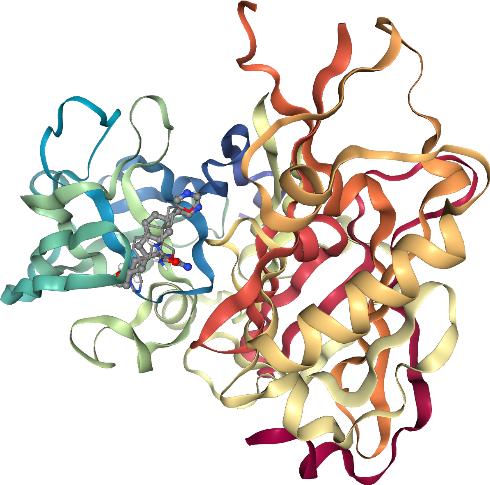

In [28]:
view._display_image()

**Docking of other ligands to our target protein BACE1 is much more complicated due to the different confirmation of the target protein when a perticular ligand binds to target. See the example below**

### dock another molecule

In [22]:
smiles = 'C[C@]1(CO[C@@](C(=N1)N)(C)C(F)(F)F)c2c(ccc(n2)NC(=O)c3c(cc(cn3)C(F)(F)F)Cl)F'

In [13]:
ligand_resname = 'BUH'
ligand = structure.select_atoms(f"resname {ligand_resname}")
pocket_center = (ligand.positions.max(axis=0) + ligand.positions.min(axis=0)) / 2
pocket_size = ligand.positions.max(axis=0) - ligand.positions.min(axis=0) + 5

ValueError: zero-size array to reduction operation maximum which has no identity